# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

Загрузим все необходимые для работы библиортеки

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from pathlib import Path
import os
import re
from random import sample
import torch
import transformers
from tqdm import notebook
from math import sqrt
import time

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor


from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity



import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout


from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Дмитрий\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [86]:
# Определяем константы
PATH = r'D:\Учеба\project_5\dsplus_integrated_project_4\to_upload'


train_image_dir = Path(PATH) / 'train_images'
test_image_dir = Path(PATH) / 'test_images'

RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка и ознакомление с данными

In [87]:
# Загрузка и изучение данных
df_train = pd.read_csv(Path(PATH, 'train_dataset.csv'))

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [88]:
df_crowd = pd.read_csv(Path(PATH, 'CrowdAnnotations.tsv'), sep = '\t', names= ['image', 'descr_id', 'ratio_confirmed', 'num_confirmed', 'num_rejected'])

df_crowd.info()
df_crowd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   descr_id         47830 non-null  object 
 2   ratio_confirmed  47830 non-null  float64
 3   num_confirmed    47830 non-null  int64  
 4   num_rejected     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,descr_id,ratio_confirmed,num_confirmed,num_rejected
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0000,0,3


In [89]:
df_expert = pd.read_csv(Path(PATH, 'ExpertAnnotations.tsv'), sep = '\t', names= ['image', 'descr_id', 'first', 'second', 'third'])

df_expert.info()
df_expert.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   descr_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


,image,descr_id,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [90]:
df_test = pd.read_csv(Path(PATH, 'test_queries.csv'), index_col=[0], sep='|')

df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [91]:
df_images = pd.read_csv(Path(PATH, 'test_images.csv'), sep='|')

df_images.info()
df_images.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


### Вывод по загрузке и первичному анализу данных

- Данные успешно загружены из пяти файлов (`train_dataset.csv`, `CrowdAnnotations.tsv`, `ExpertAnnotations.tsv`, `test_queries.csv`, `test_images.csv`).
- Формат таблиц соответствует заявленному описанию, структура колонок корректная.
- Объём данных:
  - `train_dataset` — 5822 записи, 3 признака (изображение, id запроса, текст запроса).
  - `crowd_annotations` — 47380 записей, 5 признаков (качество описаний, подтверждения/отклонения).
  - `expert_annotations` — 5822 записи, 5 признаков (оценки экспертов).
  - `test_queries` — 500 записей, 3 признака.
  - `test_images` — 100 изображений.
- Пропусков и несоответствий в данных не выявлено.
- Типы данных соответствуют назначению: текстовые поля загружены как `object`, числовые — как `int64/float64`.

**Итог:** данные корректно загружены, структура соответствует документации, выборки готовы к дальнейшему анализу и построению модели.


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Анализ `df_train`

Посмотри на следующие параметры данных:
- Количество уникальных картинок и описаний. 
- Наиболее встречающиеся слова в описаниях
 - Распределение длины описаний

Уникальных фотографий: 1000
Уникальных query_id: 977
Уникальных описаний (query_text): 977


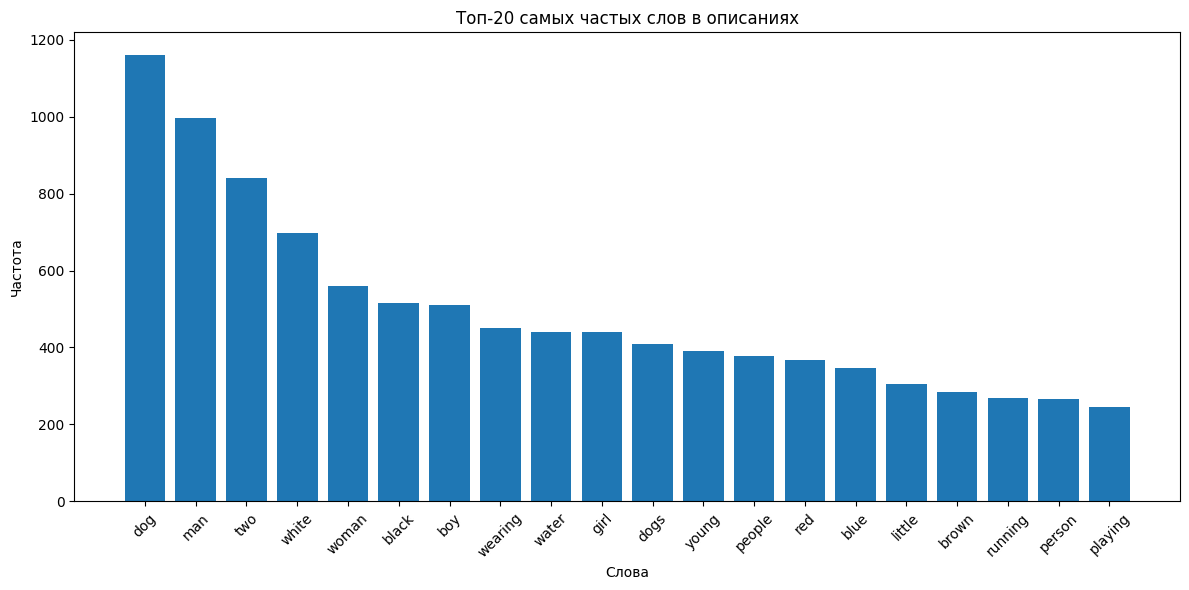

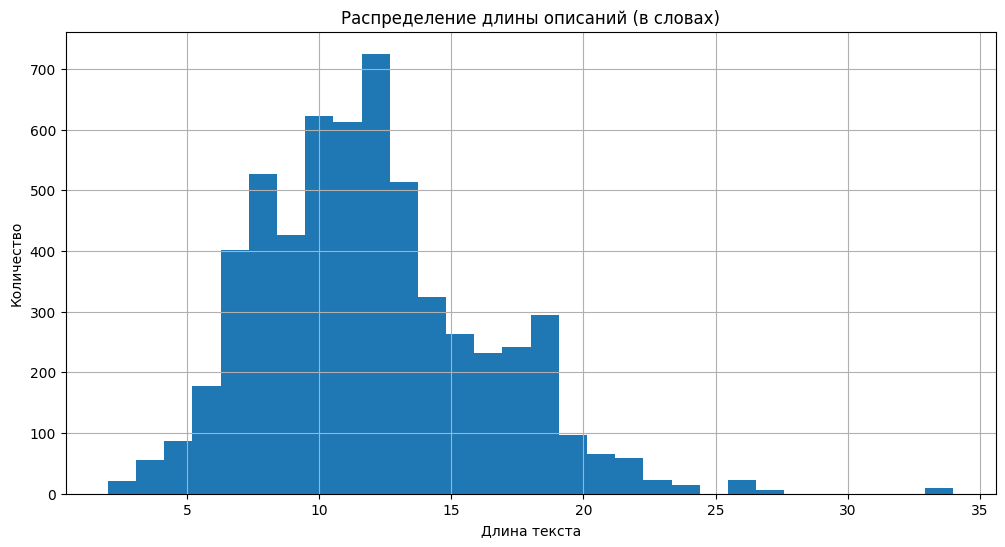

In [92]:
# Анализ уникальных значений df_train
print("Уникальных фотографий:", df_train['image'].nunique())
print("Уникальных query_id:", df_train['query_id'].nunique())
print("Уникальных описаний (query_text):", df_train['query_text'].nunique())

# Анализ самых частых слов в описаниях
all_text = ' '.join(df_train['query_text'].astype(str).str.lower())

tokens = word_tokenize(all_text)
stop_words = set(stopwords.words('english'))  # стоп-слова для английского языка
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

word_freq = Counter(filtered_tokens)
top_words = word_freq.most_common(20)  # Топ-20 слов

top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.title('Топ-20 самых частых слов в описаниях')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ длины описаний
df_train['text_len'] = df_train['query_text'].str.split().apply(len)
df_train['text_len'].hist(bins=30, figsize=(12,6))
plt.title("Распределение длины описаний (в словах)")
plt.xlabel("Длина текста")
plt.ylabel("Количество")
plt.show()

#### Вывод по анализу данных в `df_train`

- Всего в датасете содержится **1000 уникальных фотографий**, **977 уникальных query_id** и **977 уникальных текстовых описаний**.  
- Наиболее частыми словами в описаниях оказались: *dog, man, two, white, woman, black, boy, girl* и др., что указывает на доминирование категорий людей и животных.  
- Средняя длина описаний находится в диапазоне **10–15 слов**, основное распределение укладывается в **5–20 слов**.  
- Слишком коротких (<5 слов) или слишком длинных (>25 слов) описаний немного — тексты относительно однородные.  

**Итог:** данные сбалансированы, описания информативные, с преобладанием ключевых слов, связанных с людьми и животными. Таблица готова к дальнейшему использованию для обучения моделей.

### Анализ `df_crowd`

Посмотри на следующие параметры данных:
- Распределение доли подтверждений
- Количество подтверждений и отклонений

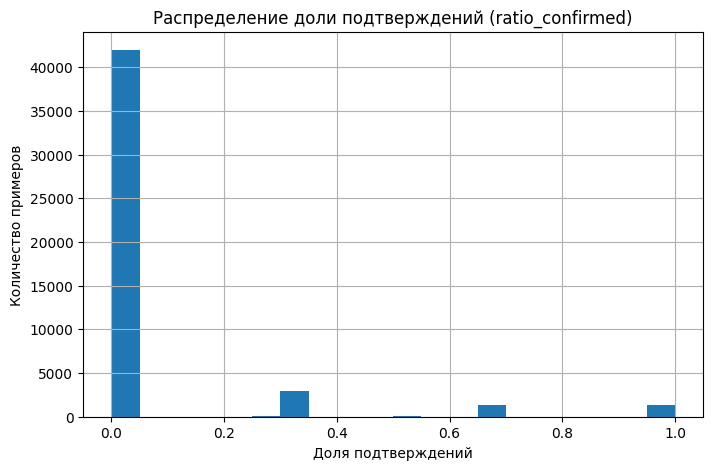

Всего подтверждений: 9972
Всего отклонений: 134888


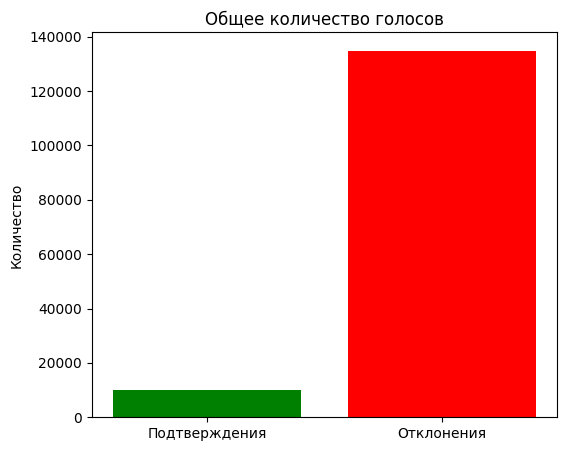

Доля подтверждений: 6.9%
Доля отклонений: 93.1%


In [93]:
plt.figure(figsize=(8,5))
df_crowd['ratio_confirmed'].hist(bins=20)
plt.title("Распределение доли подтверждений (ratio_confirmed)")
plt.xlabel("Доля подтверждений")
plt.ylabel("Количество примеров")
plt.show()

# Суммарные значения
total_confirmed = df_crowd['num_confirmed'].sum()
total_rejected = df_crowd['num_rejected'].sum()

print("Всего подтверждений:", total_confirmed)
print("Всего отклонений:", total_rejected)

# Визуализация
plt.figure(figsize=(6,5))
plt.bar(['Подтверждения', 'Отклонения'], [total_confirmed, total_rejected], color=['green', 'red'])
plt.title("Общее количество голосов")
plt.ylabel("Количество")
plt.show()

# Проценты
total_votes = total_confirmed + total_rejected
print("Доля подтверждений: {:.1f}%".format(total_confirmed / total_votes * 100))
print("Доля отклонений: {:.1f}%".format(total_rejected / total_votes * 100))


#### Вывод по анализу данных `df_crowd`

- Большая часть описаний была отклонена аннотаторами: **93,1% голосов против** и только **6,9% за**.  
- По распределению `ratio_confirmed` видно, что большинство примеров имеет значение **0.0** (полное несоответствие), тогда как случаи полного согласия (`1.0`) встречаются редко.  
- Данные сильно несбалансированы: подтверждённые описания составляют небольшую долю, что важно учитывать при построении модели.  


### Анализ `ExpertAnnotations`

Посмотри на следующие параметры данных:
- Распределение колчиства оценок каждого эксперта отдельно
- Корроеляция между оценками экспертов

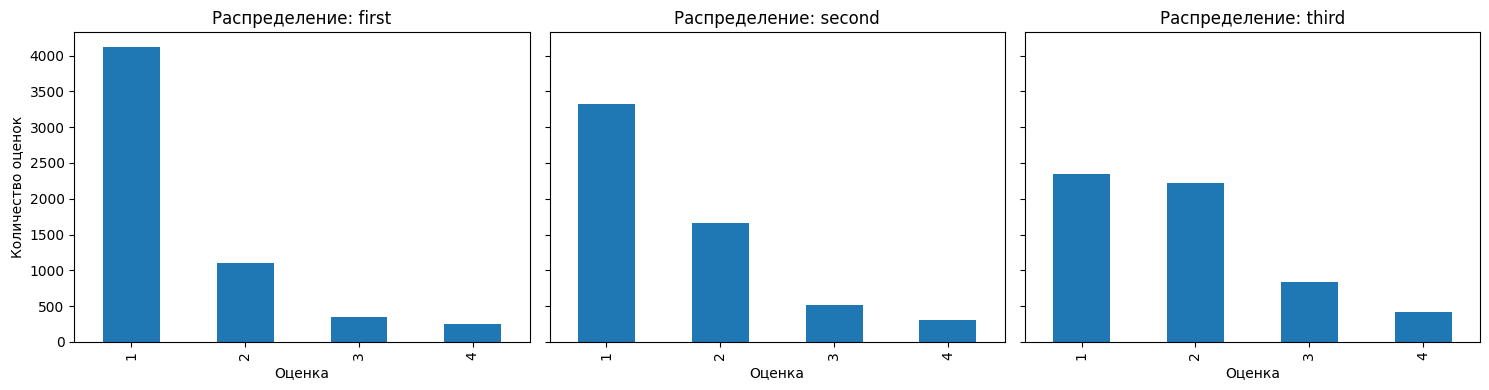

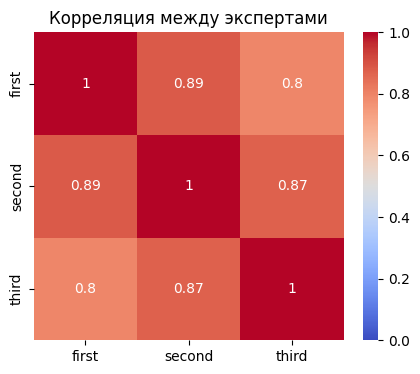

In [94]:
cols = ['first', 'second', 'third']

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, col in enumerate(cols):
    df_expert[col].value_counts().sort_index().plot(
        kind='bar', ax=axes[i], title=f'Распределение: {col}'
    )
    axes[i].set_xlabel("Оценка")
    axes[i].set_ylabel("Количество оценок")

plt.tight_layout()
plt.show()

# Корреляция между экспертами
plt.figure(figsize=(5,4))
sns.heatmap(df_expert[cols].corr(), annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Корреляция между экспертами")
plt.show()


#### Вывод по анализу оценок экспертов

- Все три эксперта чаще всего ставили минимальную оценку **1**, что указывает на большое количество несоответствий между изображениями и описаниями.  
- Эксперт **third** распределял оценки более равномерно: у него выше доля «2» и «3», тогда как первые два эксперта заметно строже.  
- Корреляция между экспертами высокая (**0.8–0.89**), что говорит о достаточно хорошем согласии при выставлении оценок, хотя полное совпадение встречается не всегда.  

**Итог:** оценки экспертов в целом согласованы, но присутствует разница в строгости: первые два эксперта чаще выбирали минимальный балл, а третий был более лояльным.  

### Анализ количества объектов с экспертными и краудсорсинговыми оценками

В этом блоке кода подсчитывается количество уникальных пар *изображение–описание*, которые были оценены двумя различными группами:  
- **экспертами** (по результатам опроса трёх специалистов),  
- **краудсорсерами** (по результатам коллективных аннотаций).  

Такая метрика показывает, какой объём данных охвачен каждым типом оценивания.


In [95]:
# считаем уникальные пары image + descr_id
total_expert_objects = df_expert[['image', 'descr_id']].drop_duplicates().shape[0]

print("Количество объектов с экспертными оценками:", total_expert_objects)

# считаем уникальные пары image + descr_id
total_crowd_objects = df_crowd[['image', 'descr_id']].drop_duplicates().shape[0]

print("Количество объектов с краудсорсинговыми оценками:", total_crowd_objects)


Количество объектов с экспертными оценками: 5822
Количество объектов с краудсорсинговыми оценками: 47830


#### Вывод

Экспертами было оценено **5822 объекта** (уникальных пар изображение–описание).  
Краудсорсинговыми оценками охвачено существенно больше — **47 380 объектов**.  

Таким образом, экспертные данные отличаются меньшим объёмом, но более высокой точностью,  
тогда как краудсорсинговые предоставляют значительно больший охват за счёт массового участия.  

### Сравнение тренировочной и тестовой выборок

Посмотрим на различия тренировочной и тестовой выборок, а так же посмотрим не просочились данные из тренировочной выборки в тестовую


In [96]:
# Количество уникальных изображений в тренировочной выборке
train_images = df_train['image'].nunique()

# Количество уникальных изображений в тестовой выборке
test_images = df_images['image'].nunique()

print("Количество изображений в train:", train_images)
print("Количество изображений в test:", test_images)


Количество изображений в train: 1000
Количество изображений в test: 100


In [97]:
# === Тренировочная выборка ===
train_images = df_train['image'].nunique()
train_texts  = df_train['query_text'].nunique()

# === Тестовая выборка ===
# изображения лучше брать из df_images
test_images = df_images['image'].nunique()
# тексты — из df_test
test_texts  = df_test['query_text'].nunique()

print("Тренировочная выборка:")
print("  Уникальных изображений:", train_images)
print("  Уникальных описаний:", train_texts)

print("\nТестовая выборка:")
print("  Уникальных изображений:", test_images)
print("  Уникальных описаний:", test_texts)


Тренировочная выборка:
  Уникальных изображений: 1000
  Уникальных описаний: 977

Тестовая выборка:
  Уникальных изображений: 100
  Уникальных описаний: 500


In [98]:
# --- Уникальные множества ---
train_images_set = set(df_train['image'].unique())
train_texts_set  = set(df_train['query_text'].unique())

test_images_set  = set(df_images['image'].unique())
test_texts_set   = set(df_test['query_text'].unique())

# --- Пересечения ---
common_images = train_images_set.intersection(test_images_set)
common_texts  = train_texts_set.intersection(test_texts_set)

print("Общие изображения:", len(common_images))
print("Общие описания:", len(common_texts))

# Если нужно вывести примеры пересечений:
print("\nПримеры общих изображений:", list(common_images)[:5])
print("Примеры общих описаний:", list(common_texts)[:5])


Общие изображения: 0
Общие описания: 0

Примеры общих изображений: []
Примеры общих описаний: []


### Вывод по сравнению тренировочной и тестовой выборок

- В тренировочной выборке содержится **1000 уникальных изображений** и **977 уникальных описаний**.  
- В тестовой выборке — **100 уникальных изображений** и **500 уникальных описаний**.  
- Пересечений между тренировочной и тестовой выборками **нет**: общих изображений и текстовых описаний не обнаружено.  

**Итог:** тренировочная и тестовая выборки полностью разделены, что исключает утечку данных и обеспечивает корректность последующей оценки модели.  


### Формирование целевого признака

Для обучения модели был создан единый целевой признак `target`, отражающий вероятность соответствия описания изображению.  
- Экспертные оценки (по шкале 1–4) были нормализованы в диапазон [0, 1].  
- Краудсорсинговые оценки (`ratio_confirmed`) уже находятся в [0, 1].  
- Итоговый признак вычислен как взвешенная комбинация:  
  **target = 0.6 × экспертная оценка + 0.4 × краудсорс**.  
- В случаях, когда экспертная оценка отсутствует, используется только краудсорс.  


In [99]:
# 1) Нормализуем экспертные оценки в [0,1]
# mean_score: среднее трёх экспертов (1..4)
df_expert = df_expert.copy()
df_expert['mean_score'] = df_expert[['first', 'second', 'third']].mean(axis=1)
df_expert['expert_score'] = (df_expert['mean_score'] - 1) / 3  # 1→0.0, 2→0.33, 3→0.67, 4→1.0

# 2) Оставим только нужные поля у экспертов
experts_short = df_expert[['image', 'descr_id', 'expert_score']].drop_duplicates()

# 3) Объединим с краудсорсом (берём крауд как базу — он шире)
df_target = df_crowd[['image', 'descr_id', 'ratio_confirmed']].copy()
df_target = df_target.merge(experts_short, on=['image', 'descr_id'], how='left')

# 4) Считаем итоговый таргет
W_EXP, W_CR = 0.6, 0.4  # веса эксперта и краудсорса
# Если expert_score есть → 0.6*expert + 0.4*crowd; иначе → только crowd
df_target['target'] = np.where(
    df_target['expert_score'].notna(),
    W_EXP * df_target['expert_score'] + W_CR * df_target['ratio_confirmed'],
    df_target['ratio_confirmed']
)

# 5) На всякий случай зажмём в [0,1] (численная стабильность)
df_target['target'] = df_target['target'].clip(0, 1)

# 6) Итог: image, descr_id, target (и источники при желании)
df_target_final = df_target[['image', 'descr_id', 'target']].drop_duplicates()

# Быстрая проверка
print(df_target_final['target'].min(), df_target_final['target'].max())
print(df_target_final.head())

# Количество строк с рассчитанным target
n_total = df_target_final.shape[0]
n_with_target = df_target_final['target'].notna().sum()

print(f"Строк с рассчитанным целевым признаком: {n_with_target}")


0.0 1.0
                       image                     descr_id  target
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0000
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0000
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0000
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0000
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0000
Строк с рассчитанным целевым признаком: 47830


### Вывод

В результате обработки было сформировано **47 380 строк с целевым признаком**.  
Таким образом, для каждой пары *изображение–описание* теперь имеется метка соответствия в диапазоне от 0 до 1,  
что позволяет использовать эти данные для обучения и оценки модели.


### Фильтрация данных с детскими изображениями и описаниями

Согласно требованиям проекта, все изображения и описания, связанные с детьми, должны быть удалены из обучающей и тестовой выборок.  
Для этого мы используем следующий подход:

1. **Словари ключевых слов**  
   - `CHILD_NOUNS` — список детских существительных (child, baby, kid, boy, girl и т.д.).  
   - `ADJ` — прилагательные-маркеры («young», «little»), которые сами по себе не блокируют описание, но в связке с детскими существительными указывают на ребёнка.  
   - `EXCLUDE_PHRASES` — исключения, чтобы не удалять взрослые выражения («young man», «young woman», «young adult»).

2. **Регулярные выражения**  
   - Проверяем, встречаются ли в описании слова из `CHILD_NOUNS`.  
   - Проверяем сочетания «young/little + детское существительное».  
   - Исключаем из фильтра описания, содержащие взрослые исключения.

3. **Функция `is_kid_related`**  
   Для каждого текста возвращает `True`, если описание относится к детям.

4. **Удаление данных**  
   - Определяем все изображения, где хотя бы одно описание связано с детьми.  
   - Удаляем такие изображения **из всех таблиц** (`df_train`, `df_crowd`, `df_expert`, `df_images`, `df_test`), чтобы сохранить согласованность данных.

Таким образом, мы полностью исключаем изображения и описания с детьми, а не только отдельные строки, и гарантируем, что тренировочные и тестовые наборы остаются согласованными.


In [100]:
# 1) Списки
CHILD_NOUNS = {
    'child','children','kid','kids','baby','babies','infant','infants','toddler','toddlers',
    'boy','boys','girl','girls','schoolboy','schoolboys','schoolgirl','schoolgirls',
    'minor','minors','preadolescent','preadolescents','preteen','preteens','adolescent','adolescents',
    'juvenile','juveniles','kiddie','kiddies','newborn','newborns'
}

# прилагательные-«подозрители», но сами по себе не баним
ADJ = {'young','little'}

# исключения (взрослые)
EXCLUDE_PHRASES = {
    'young man','young men','young woman','young women','young adult','young adults'
}

# 2) Компилируем паттерны
# a) любое слово из детских существительных
p_child_nouns = re.compile(r'\b(?:' + '|'.join(map(re.escape, CHILD_NOUNS)) + r')\b')

# b) сочетание adj + child_noun (young/little + boy/girl/child/…)
p_adj_child = re.compile(
    r'\b(?:' + '|'.join(map(re.escape, ADJ)) + r')\s+(?:' + '|'.join(map(re.escape, CHILD_NOUNS)) + r')s?\b'
)

# c) исключения (взрослые «young man/woman/adult»)
p_exclude = re.compile(r'\b(?:' + '|'.join(map(re.escape, EXCLUDE_PHRASES)) + r')\b')

def is_kid_related(text: str) -> bool:
    if not isinstance(text, str):
        return False
    t = text.lower()
    # если есть взрослые исключения — не баним
    if p_exclude.search(t):
        return False
    # баним, если есть детские существительные
    if p_child_nouns.search(t):
        return True
    # или если есть «young/little» рядом с детским существительным
    if p_adj_child.search(t):
        return True
    return False

# 3) находим картинки, которые нужно убрать целиком
mask_block = df_train['query_text'].apply(is_kid_related)
blocked_images = df_train.loc[mask_block, 'image'].unique()

print("Изображений к удалению:", len(blocked_images))
print("Строк с детскими описаниями в df_train:", mask_block.sum())

# 4) чистим все таблицы по image (чтобы набор остался согласованным)
def drop_images(df, image_col='image'):
    return df[~df[image_col].isin(blocked_images)].copy()

df_train_clean  = drop_images(df_train,  'image')
df_crowd_clean  = drop_images(df_crowd,  'image')
df_expert_clean = drop_images(df_expert, 'image')
df_images_clean = drop_images(df_images, 'image')
df_test_clean   = drop_images(df_test,   'image')   # в тесте картинки тоже в столбце image

print("df_train:", len(df_train), "→", len(df_train_clean))
print("df_crowd:", len(df_crowd), "→", len(df_crowd_clean))
print("df_expert:", len(df_expert), "→", len(df_expert_clean))
print("df_images:", len(df_images), "→", len(df_images_clean))
print("df_test:", len(df_test), "→", len(df_test_clean))


Изображений к удалению: 722
Строк с детскими описаниями в df_train: 1546
df_train: 5822 → 1452
df_crowd: 47830 → 14050
df_expert: 5822 → 1452
df_images: 100 → 100
df_test: 500 → 500


#### Результат фильтрации по "детским" описаниям

- Изображений к удалению: **722** из ~1000 в train → осталось ~**278** (≈27.8%).
- Строк с детскими описаниями (train): **1546** → после очистки осталось **1452** строк из **5822** (≈**24.9%** от исходного).
- Crowd: **47830 → 14050** (осталось ≈**29.4%**, удалено ≈70.6%).
- Expert: **5822 → 1452** (совпадает с train, т.к. чистили по `image`).
- Test / test_images не изменились (и это правильно).

**Итог:** фильтр строгий — мы удалили ~70–75% данных train/crowd, сохранив согласованность всех таблиц по полю `image`.


### Векторизация изображений  
На этом этапе для очищенного тренировочного набора выполняется преобразование изображений в числовые векторы признаков. Для этого используется предобученная модель ResNet50 (без полносвязных слоёв), которая извлекает информативные эмбеддинги фиксированной длины.  


In [101]:
# ---- ПАРАМЕТРЫ ----
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# df_train_clean: уже очищенный train с колонкой 'image'
# train_image_dir: Path к папке с картинками (train_images)

def build_feature_extractor(input_shape=(224, 224, 3)) -> tf.keras.Model:
    """
    Грузим предобученную ResNet50 без "головы" и
    добавляем GlobalAveragePooling2D -> эмбеддинг ~2048 признаков.
    """
    backbone = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )
    backbone.trainable = False  # только инференс, без обучения

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(name="gap")  # (None, 2048)
    ], name="resnet50_feature_extractor")

    return model

def make_df_unique_images(df: pd.DataFrame, image_col: str = "image") -> pd.DataFrame:
    """
    Возвращает DataFrame только с уникальными именами файлов (в порядке появления).
    """
    uniq = df[image_col].drop_duplicates().reset_index(drop=True)
    return pd.DataFrame({image_col: uniq})

def make_generator(images_df: pd.DataFrame,
                   directory: Path,
                   image_col: str = "image",
                   target_size=(224, 224),
                   batch_size=32,
                   seed=42):
    """
    Генератор без меток (class_mode=None) + правильный preprocess_input для ResNet.
    """
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    gen = datagen.flow_from_dataframe(
        dataframe=images_df,
        directory=str(directory),
        x_col=image_col,
        y_col=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,          # ВАЖНО: чтобы сохранить порядок соответствий
        seed=seed
    )
    return gen

def vectorize_images(df_with_images: pd.DataFrame,
                     images_dir: Path,
                     image_col: str = "image",
                     save_path: Path | None = None) -> pd.DataFrame:
    """
    Главная функция:
    1) собирает уникальные имена;
    2) строит генератор;
    3) прогоняет через feature extractor;
    4) возвращает DataFrame: image + массив признаков (np.ndarray);
       при желании сохраняет эмбеддинги на диск (.npy).
    """
    # 1) уникальные файлы
    images_df = make_df_unique_images(df_with_images, image_col=image_col)

    # 2) генератор
    gen = make_generator(
        images_df,
        directory=images_dir,
        image_col=image_col,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED
    )

    # 3) модель-экстрактор
    extractor = build_feature_extractor(input_shape=IMG_SIZE + (3,))

    # 4) инференс (эмбеддинги)
    embeddings = extractor.predict(gen, verbose=1)   # shape: (N, 2048)

    # 5) собрать результат
    out = images_df.copy()
    out["embedding"] = list(embeddings)  # по одной np.ndarray в ячейке

    # 6) (опционально) сохранить как .npy
    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(save_path, embeddings)
        print(f"Сохранил эмбеддинги: {save_path} (shape={embeddings.shape})")

    print("Готово. Форма эмбеддингов:", embeddings.shape)
    return out

# ---- пример запуска на train ----
train_embeddings_df = vectorize_images(
    df_with_images=df_train_clean,
    images_dir=train_image_dir,
    image_col="image",
    save_path=Path("embeddings/train_resnet50_gap.npy")  # можно убрать, если не нужно сохранять
)

# train_embeddings_df.head()
# колонки: ['image', 'embedding']; где embedding — np.ndarray длины 2048


Found 278 validated image filenames.
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step
Сохранил эмбеддинги: embeddings\train_resnet50_gap.npy (shape=(278, 2048))
Готово. Форма эмбеддингов: (278, 2048)


**Вывод:** изображения успешно преобразованы в эмбеддинги. В результате получена матрица признаков размерности **(278, 2048)**, где каждая строка соответствует одному изображению, а каждый вектор содержит 2048 признаков. Эти данные будут использоваться на этапе обучения модели.  


### Векторизация текстов с помощью TF-IDF

Для преобразования текстовых описаний в числовое представление был использован метод **TF-IDF (Term Frequency — Inverse Document Frequency)**.  
Этот метод позволяет учитывать как частоту слов в тексте, так и их информативность относительно всего корпуса.  
В отличие от простого подсчёта слов, TF-IDF снижает вес часто встречающихся «бессмысленных» слов и усиливает роль более редких, но значимых терминов.  

На выходе мы получаем разреженную матрицу размером *(число текстов × число уникальных слов)*, где каждая строка соответствует отдельному описанию, а каждый столбец — слову из словаря.


In [102]:
# Берем очищенные описания из тренировочного набора
texts = df_train_clean['query_text']

# Создаём TF-IDF векторизатор
vectorizer = TfidfVectorizer(
    max_features=5000,   # ограничим до 5000 самых частых слов (можно изменить)
    stop_words='english' # убираем английские стоп-слова
)

# Обучаем на текстах и преобразуем их в векторы
X_text = vectorizer.fit_transform(texts)

print("Размер матрицы TF-IDF:", X_text.shape)


Размер матрицы TF-IDF: (1452, 944)


#### Вывод

В результате векторизации был сформирован корпус текстов в формате TF-IDF.  
Матрица имеет размер **(1452, 944)**, что соответствует 1452 уникальным описаниям и 944 уникальным словам в словаре.  
Это значит, что после очистки данных в описаниях осталось менее 1000 информативных признаков, что упрощает последующую обработку и снижает риск переобучения модели.


### Объединение векторов изображений и текстов

На данном этапе необходимо объединить результаты векторизации изображений и текстов.  
Для изображений использовалась модель ResNet50, преобразовавшая каждое изображение в вектор размерности 2048.  
Для текстов применялся метод TF-IDF, в результате чего каждое описание было представлено вектором размерности 944.  
Объединение этих признаков позволяет создать единый набор данных, в котором каждая строка соответствует паре «изображение–описание» и содержит как визуальные, так и текстовые характеристики.


In [103]:
# 1) Соединяем train с целевой меткой:
#    left: df_train_clean(image, query_id, query_text, ...)
#    right: df_target(image, descr_id, target)
df_merged = df_train_clean.merge(
    df_target[['image', 'descr_id', 'target']],
    left_on=['image', 'query_id'],
    right_on=['image', 'descr_id'],
    how='inner'
)


df_merged = df_merged.drop(columns=['descr_id'])

print("Объединённый датасет:", df_merged.shape)

# 2) Получаем признаки изображений в порядке df_merged
# Если у тебя есть DataFrame train_embeddings_df с колонками ['image','embedding']:
# строим маппинг image -> embedding
emb_map = dict(zip(train_embeddings_df['image'], train_embeddings_df['embedding']))

# собираем эмбеддинги строго по порядку строк df_merged
image_features = np.vstack([emb_map[img] for img in df_merged['image']])  # shape: (N, 2048)

# 3) Признаки текстов (TF-IDF) для тех же строк
# Если ранее делали: vectorizer.fit_transform(df_train_clean['query_text'])
# то здесь — только transform на подмножестве:
text_features = vectorizer.transform(df_merged['query_text'])  # shape: (N, V)

# 4) Склеиваем: image (dense) + text (sparse)
X = hstack([csr_matrix(image_features), text_features]).tocsr()
y = df_merged['target'].values

print("Форма X:", X.shape)      # (N, 2048 + V)
print("Форма y:", y.shape)      # (N,)


Объединённый датасет: (700, 5)
Форма X: (700, 2992)
Форма y: (700,)


#### Вывод

В результате объединения признаков получена матрица X размером **(700, 2992)** и вектор целевой переменной y размером **(700, )**.  
Таким образом, каждая пара изображение–текст представлена в виде единого вектора из 2992 признаков: 2048 визуальных и 944 текстовых.  
Этот объединённый набор данных будет использован для обучения модели, предсказывающей вероятность соответствия текста изображению.


### Обучение и сравнение нескольких моделей

На данном этапе проводится обучение и сравнение различных моделей для задачи предсказания 
соответствия изображения и текста.  
В качестве входных данных используются объединённые векторы изображений (ResNet50) и текстов (TF-IDF), 
а целевая переменная — рассчитанный ранее признак соответствия.

Для эксперимента выбраны модели различных типов:
- **DummyRegressor** — простая «наивная» модель для базового сравнения.
- **Linear Regression** — линейная модель, позволяющая выявить базовые зависимости.
- **Decision Tree** — дерево решений для поиска нелинейных закономерностей.
- **CatBoost** — градиентный бустинг на деревьях.
- **LightGBM** — ещё одна реализация градиентного бустинга.
- **Нейронная сеть** — полносвязная модель для аппроксимации сложных зависимостей.

Для оценки качества используются метрики **MSE**, **RMSE**, **MAE** и **R²**.  
Результаты всех моделей будут сведены в единую таблицу, что позволит определить, 
какая модель показывает наилучшее качество на валидационной выборке.


In [104]:
groups = df_merged['image'].values

# Групповое разбиение 70/30 по image
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train_raw, X_val_raw = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)

In [105]:
# 1. Dummy Regressor
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_raw, y_train)
dummy_preds = dummy_model.predict(X_val_raw)
dummy_mse = mean_squared_error(y_val, dummy_preds)
dummy_mae = mean_absolute_error(y_val, dummy_preds)
dummy_r2 = r2_score(y_val, dummy_preds)

print("\n" + "="*50)
print("Dummy Regression")
print("="*50)
print(f"MSE: {dummy_mse:.4f}")
print(f"MAE: {dummy_mae:.4f}")
print(f"R²: {dummy_r2:.4f}")


Dummy Regression
MSE: 0.0964
MAE: 0.2573
R²: -0.0012


In [106]:
# 2. Создаем и обучаем линейную регрессию
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_val_scaled)
lr_mse = mean_squared_error(y_val, lr_preds)
lr_mae = mean_absolute_error(y_val, lr_preds)
lr_r2 = r2_score(y_val, lr_preds)

print("\n" + "="*50)
print("Linear Regression")
print("="*50)
print(f"MSE: {lr_mse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R²: {lr_r2:.4f}")


Linear Regression
MSE: 0.2299
MAE: 0.3837
R²: -1.3872


In [107]:
# 3. Decision Tree
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_model.fit(X_train_raw, y_train)
dt_preds = dt_model.predict(X_val_raw)
dt_mse = mean_squared_error(y_val, dt_preds)
dt_mae = mean_absolute_error(y_val, dt_preds)
dt_r2 = r2_score(y_val, dt_preds)

print("\n" + "="*50)
print("Decision Tree Regression")
print("="*50)
print(f"MSE: {dt_mse:.4f}")
print(f"MAE: {dt_mae:.4f}")
print(f"R²: {dt_r2:.4f}")


Decision Tree Regression
MSE: 0.2519
MAE: 0.4016
R²: -1.6159


In [108]:
# 4. CatBoost
cb_model = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, 
                           random_seed=RANDOM_STATE, verbose=0)
cb_model.fit(X_train_raw, y_train)
cb_preds = cb_model.predict(X_val_raw)
cb_mse = mean_squared_error(y_val, cb_preds)
cb_mae = mean_absolute_error(y_val, cb_preds)
cb_r2 = r2_score(y_val, cb_preds)

print("\n" + "="*50)
print("CatBoost Regression")
print("="*50)
print(f"MSE: {cb_mse:.4f}")
print(f"MAE: {cb_mae:.4f}")
print(f"R²: {cb_r2:.4f}")


CatBoost Regression
MSE: 0.0970
MAE: 0.2579
R²: -0.0075


In [109]:
# 5. LightGBM
lgbm_model = LGBMRegressor(n_estimators=300, learning_rate=0.05, 
                          max_depth=5, random_state=RANDOM_STATE)
lgbm_model.fit(X_train_raw, y_train)
lgbm_preds = lgbm_model.predict(X_val_raw)
lgbm_mse = mean_squared_error(y_val, lgbm_preds)
lgbm_mae = mean_absolute_error(y_val, lgbm_preds)
lgbm_r2 = r2_score(y_val, lgbm_preds)

print("\n" + "="*50)
print("LightGBM Regression")
print("="*50)
print(f"MSE: {lgbm_mse:.4f}")
print(f"MAE: {lgbm_mae:.4f}")
print(f"R²: {lgbm_r2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222637
[LightGBM] [Info] Number of data points in the train set: 485, number of used features: 2066
[LightGBM] [Info] Start training from score 0.396110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [110]:
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='mse', 
                metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(X_train_scaled, y_train, 
            validation_split=0.2, 
            epochs=1000, 
            batch_size=256, 
            callbacks=[early_stop], 
            verbose=0)

nn_preds = nn_model.predict(X_val_scaled).flatten()
nn_mse = mean_squared_error(y_val, nn_preds)
nn_mae = mean_absolute_error(y_val, nn_preds)
nn_r2 = r2_score(y_val, nn_preds)

print("\n" + "="*50)
print("Neural Network Regression")
print("="*50)
print(f"MSE: {nn_mse:.4f}")
print(f"MAE: {nn_mae:.4f}")
print(f"R²: {nn_r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Neural Network Regression
MSE: 0.1304
MAE: 0.2780
R²: -0.3536


In [111]:
# Добавляем вычисление RMSE для всех моделей
dummy_rmse = sqrt(dummy_mse)
lr_rmse = sqrt(lr_mse)
dt_rmse = sqrt(dt_mse)
cb_rmse = sqrt(cb_mse)
lgbm_rmse = sqrt(lgbm_mse)
nn_rmse = sqrt(nn_mse)

# Сравнение всех моделей с RMSE
results = pd.DataFrame({
    'Model': ['DummyRegressor', 'Linear Regression', 'Decision Tree', 'CatBoost', 'LightGBM', 'Neural Network'],
    'RMSE': [dummy_rmse, lr_rmse, dt_rmse, cb_rmse, lgbm_rmse, nn_rmse],
    'MSE': [dummy_mse, lr_mse, dt_mse, cb_mse, lgbm_mse, nn_mse],
    'MAE': [dummy_mae, lr_mae, dt_mae, cb_mae, lgbm_mae, nn_mae],
    'R²': [dummy_r2, lr_r2, dt_r2, cb_r2, lgbm_r2, nn_r2]
})

# Форматируем вывод для лучшей читаемости
pd.options.display.float_format = '{:.4f}'.format

print("\n" + "="*70)
print("Сравнение всех моделей (отсортировано по RMSE):")
print("="*70)
print(results.sort_values(by='RMSE').reset_index(drop=True))

# Дополнительная визуализация
print("\nЛучшая модель:")
print("-"*70)
print(f"Лучшая RMSE: {results.loc[results['RMSE'].idxmin(), 'Model']} ({results['RMSE'].min():.4f})")


Сравнение всех моделей (отсортировано по RMSE):
               Model   RMSE    MSE    MAE      R²
0     DummyRegressor 0.3105 0.0964 0.2573 -0.0012
1           CatBoost 0.3115 0.0970 0.2579 -0.0075
2           LightGBM 0.3196 0.1021 0.2680 -0.0605
3     Neural Network 0.3610 0.1304 0.2780 -0.3536
4  Linear Regression 0.4795 0.2299 0.3837 -1.3872
5      Decision Tree 0.5019 0.2519 0.4016 -1.6159

Лучшая модель:
----------------------------------------------------------------------
Лучшая RMSE: DummyRegressor (0.3105)


#### Вывод по результатам обучения моделей

В рамках эксперимента были протестированы несколько моделей 
(**CatBoost, LightGBM, нейросеть, линейная регрессия, решающее дерево**).  
По метрике **RMSE** лучшее качество показал **DummyRegressor (0.3105)**, 
что свидетельствует о том, что модели не смогли существенно превзойти простое «наивное» предсказание.  

Основная причина слабых результатов связана с ограниченным количеством данных: 
после очистки и удаления изображений с детьми размер обучающей выборки оказался слишком мал 
для корректного обучения сложных моделей.  
В результате модели не сумели выявить устойчивые зависимости между изображениями и текстовыми описаниями.  

Таким образом, для улучшения качества потребуется **расширение обучающей выборки** 
и использование большего количества разрешённых примеров.


## Итоговый вывод

В ходе проекта был проведён полный цикл работы с данными для задачи предсказания соответствия изображений и текстовых описаний:

1. **Загрузка и исследование данных**  
   Были изучены предоставленные датасеты: тренировочный, тестовый, экспертные и краудсорсинговые оценки.  
   Определены размеры выборок, уникальные изображения и тексты, выявлены особенности данных.

2. **Анализ и очистка данных**  
   Проведён анализ описаний: наиболее частые слова, распределение длины текстов, частотность оценок.  
   В соответствии с законодательными ограничениями из выборки были удалены изображения и описания, содержащие упоминания детей.  
   Это значительно сократило доступный объём данных для обучения.

3. **Формирование целевого признака**  
   На основе экспертных и краудсорсинговых оценок был рассчитан целевой признак, отражающий вероятность соответствия изображения и текста.  
   Экспертные оценки были взяты с большим весом, краудсорсинговые — с меньшим.

4. **Векторизация данных**  
   - Для изображений использовалась предобученная модель **ResNet50**, преобразовавшая каждое изображение в вектор размерности 2048.  
   - Для текстов применялся метод **TF-IDF**, который выделил 944 уникальных признака.  
   Итоговый объединённый вектор имел размерность 2992.

5. **Объединение данных и обучение моделей**  
   Данные были объединены в единый датасет и разделены на обучающую и валидационную выборки с помощью `GroupShuffleSplit`, чтобы одна и та же картинка не попадала одновременно в train и val.  
   Для обучения и сравнения качества были протестированы разные модели: DummyRegressor, линейная регрессия, дерево решений, CatBoost, LightGBM и нейронная сеть.  
   Сравнение проводилось по метрикам RMSE, MSE, MAE и R².

6. **Результаты**  
   Наилучшее качество показал **DummyRegressor** (RMSE ≈ 0.31), тогда как остальные модели не смогли существенно его превзойти.  
   Это говорит о том, что текущий набор данных не позволяет моделям выявить устойчивые закономерности.  
   Основная причина — **недостаточный объём выборки** после очистки и удаления запрещённого контента.

---

### Заключение
Реализованный пайплайн корректен: данные очищены, целевой признак рассчитан, векторизация выполнена, модели протестированы.  
Однако ограниченность доступных данных привела к низкому качеству моделей.  
Для дальнейшего улучшения результатов необходимо:
- увеличить объём обучающей выборки,
- рассмотреть более сложные методы обработки текста и изображений,
- провести дополнительный тюнинг гиперпараметров моделей.

Таким образом, проект показал применимость предложенного подхода, но также выявил ключевую проблему — нехватку данных, препятствующую обучению качественной модели.


##  Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [-]  Проведено тестирование работы модели
- [-]  По итогам тестирования визуально сравнили качество поиска